# **Introduction**
- Why this data set? This data is interesting to me because my family flies quite often. I am also curious to know what is a good time to fly that best avoids delay.

- Data description: The data contains the flight arrival and departure details for all commercial flights in the US from October 1987 to April 2008.
The data consist of 120 million records. Its size is 12GB of uncompressed files.


# **Dataset**

- Origin: [Data Expo 1987 - 2009 - Airline on-time performance](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009)

- Structure: The data came as a CSV and had 4 types of structure
      
      Arrival and Departure Table
      |-- Year: 1987-2008
      |-- Month: 12-Jan
      |-- DayofMonth: 31-Jan
      |-- DayOfWeek: 1 (Monday) - 7 (Sunday)
      |-- DepTime: "actual departure time (local, hhmm)"
      |-- CRSDepTime: "scheduled departure time (local, hhmm)"
      |-- ArrTime: "actual arrival time (local, hhmm)"
      |-- CRSArrTime: "scheduled arrival time (local, hhmm)"
      |-- UniqueCarrier: unique carrier code
      |-- FlightNum: flight number
      |-- TailNum: plane tail number
      |-- ActualElapsedTime: in minutes
      |-- CRSElapsedTime: in minutes
      |-- AirTime: in minutes
      |-- ArrDelay: "arrival delay, in minutes"
      |-- DepDelay: "departure delay, in minutes"
      |-- Origin: origin IATA airport code
      |-- Dest: destination IATA airport code
      |-- Distance: in miles
      |-- TaxiIn: "taxi in time, in minutes"
      |-- TaxiOut: taxi out time in minutes
      |-- Cancelled: was the flight canceled?
      |-- CancellationCode: "reason for cancellation (A = carrier, B = weather, C = NAS, D = security)"
      |-- Diverted: "1 = yes, 0 = no"
      |-- CarrierDelay: in minutes
      |-- WeatherDelay: in minutes
      |-- NASDelay: in minutes
      |-- SecurityDelay: in minutes
      |-- LateAircraftDelay: in minutes
      
      Airport Info Table
      |-- iata
      |-- airport
      |-- city
      |-- state
      |-- country
      |-- lat
      |-- long
      
      Plane Info Table
      |-- tailnum
      |-- type
      |-- manufacturer
      |-- issue_date
      |-- model
      |-- status
      |-- aircraft_type
      |-- engine_type
      |-- year_made
      
      Carrier Name Table
      |-- Code
      |-- Description

  
  

# **Questions**
  + When is the best time of day of the week to fly to avoid delay?
  + When is the best time of day of the month to fly to avoid delays?
  + When is the best time of the month of the year to fly to avoid delays?
  + What is the best/worst carrier to avoid delay?
  + How does the number of flights in BOS airport change over time?


# **Problem Decomposition**


- Import Spark Functions

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import types as sparktypes
from pyspark.sql.functions import col, split, trim
import pyspark.sql.functions as pyspar

from google.colab import drive
drive.mount('/content/drive')

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

sc = SparkContext()
spark = SparkSession(sc)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u342-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


- Read CSV and Set Up DataFrame

In [ ]:
file_names = [
    '/content/drive/MyDrive/369_final_project_data/1987.csv',
    '/content/drive/MyDrive/369_final_project_data/1988.csv',
    '/content/drive/MyDrive/369_final_project_data/1989.csv',
    '/content/drive/MyDrive/369_final_project_data/1990.csv',
    '/content/drive/MyDrive/369_final_project_data/1991.csv',
    '/content/drive/MyDrive/369_final_project_data/1992.csv',
    '/content/drive/MyDrive/369_final_project_data/1993.csv',
    '/content/drive/MyDrive/369_final_project_data/1994.csv',
    '/content/drive/MyDrive/369_final_project_data/1995.csv',
    '/content/drive/MyDrive/369_final_project_data/1996.csv',
    '/content/drive/MyDrive/369_final_project_data/1997.csv',
    '/content/drive/MyDrive/369_final_project_data/1998.csv',
    '/content/drive/MyDrive/369_final_project_data/1999.csv',
    '/content/drive/MyDrive/369_final_project_data/2000.csv',
    '/content/drive/MyDrive/369_final_project_data/2001.csv',
    '/content/drive/MyDrive/369_final_project_data/2002.csv',
    '/content/drive/MyDrive/369_final_project_data/2003.csv',
    '/content/drive/MyDrive/369_final_project_data/2004.csv',
    '/content/drive/MyDrive/369_final_project_data/2005.csv',
    '/content/drive/MyDrive/369_final_project_data/2006.csv',
    '/content/drive/MyDrive/369_final_project_data/2007.csv',
    '/content/drive/MyDrive/369_final_project_data/2008.csv'
]

for i in range(0, 22):
  curr_df = spark.read.csv(
      path=file_names[i],
      sep=',',
      header=True,
      quote='"',
      inferSchema=True
  )

  if i == 0:
    temp_df = curr_df
  else:
    temp_df = temp_df.union(curr_df)

airports_csv = spark.read.csv(
    path='/content/drive/MyDrive/369_final_project_data/airports.csv',
    sep=',',
    header=True,
    quote='"',
    inferSchema=True
)

carriers_csv = spark.read.csv(
    path='/content/drive/MyDrive/369_final_project_data/carriers.csv',
    sep=',',
    header=True,
    quote='"',
    inferSchema=True
)

plane_data_csv = spark.read.csv(
    path='/content/drive/MyDrive/369_final_project_data/plane-data.csv',
    sep=',',
    header=True,
    quote='"',
    inferSchema=True
).withColumnRenamed('year', 'year_made')


- Join Tables and Clean Up Data

In [ ]:
all_tables = temp_df.join(airports_csv, airports_csv['iata'] == temp_df['Dest'], 'leftOuter') \
              .join(carriers_csv, carriers_csv['Code'] == temp_df['UniqueCarrier'], 'leftOuter') \
              .join(plane_data_csv, plane_data_csv['tailnum'] == temp_df['TailNum'], 'leftOuter') \
              .withColumn('Year', temp_df.Year.cast('int')) \
              .withColumn('Month', temp_df.Month.cast('int')) \
              .withColumn('DayofMonth', temp_df.DayofMonth.cast('int')) \
              .withColumn('DayOfWeek', temp_df.DayOfWeek.cast('int')) \
              .withColumn('CRSDepTime', temp_df.CRSDepTime.cast('int')) \
              .withColumn('CRSArrTime', temp_df.CRSArrTime.cast('int')) \
              .withColumn('FlightNum', temp_df.FlightNum.cast('int')) \
              .withColumn('CRSElapsedTime', temp_df.CRSElapsedTime.cast('int')) \
              .withColumn('Distance', temp_df.Distance.cast('int')) \
              .withColumn('TaxiIn', temp_df.TaxiIn.cast('int')) \
              .withColumn('TaxiOut', temp_df.TaxiOut.cast('int')) \
              .withColumn('Cancelled', temp_df.Cancelled.cast('int')) \
              .withColumn('Diverted', temp_df.Diverted.cast('int')) \
              .withColumn('CarrierDelay', temp_df.CarrierDelay.cast('int')) \
              .withColumn('WeatherDelay', temp_df.WeatherDelay.cast('int')) \
              .withColumn('NASDelay', temp_df.NASDelay.cast('int')) \
              .withColumn('SecurityDelay', temp_df.SecurityDelay.cast('int')) \
              .withColumn('LateAircraftDelay', temp_df.LateAircraftDelay.cast('int')) \
              .withColumn('ArrDelay', temp_df.ArrDelay.cast('int')) \
              .withColumn('DepDelay', temp_df.DepDelay.cast('int')) \
              .withColumn('year_made', plane_data_csv.year_made.cast('int')) \
              .na.fill('0')

print('There are ' + str(all_tables.count()) + ' records.')
all_tables.show(5)
all_tables.printSchema()


There are 118914458 records.
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+----+--------------------+-------------+-----+-------+-----------+------------+----+--------------------+-------+----+------------+----------+-----+------+-------------+-----------+---------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|iata|             airport|         city|state|country|        lat|        long|Code|         Description|tailnum|type|manufacturer|issue_date|model|status|aircraft_type|engine_t

- Calculate and Show Results

When is the best time of day of the week to fly to avoid delay?


+---------+-----------------+------------------+
|DayOfWeek|    avg(ArrDelay)|     avg(DepDelay)|
+---------+-----------------+------------------+
|        1|6.658458162785254| 7.785153647113321|
|        2|5.964557986964691| 6.818597695294134|
|        3| 7.13974180582594| 7.649236087527059|
|        4| 9.00286337943904| 9.250652547378548|
|        5|9.626929909945117|10.124371035200832|
|        6|4.159880237930146|6.8468370713904765|
|        7|6.420030930522413| 8.289050632190788|
+---------+-----------------+------------------+



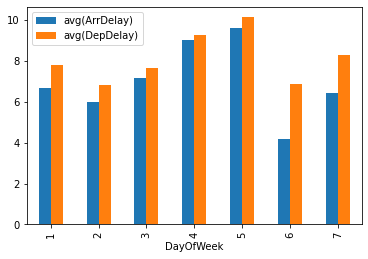

In [ ]:
question_1 = all_tables.groupBy(col('DayOfWeek')).mean('ArrDelay', 'DepDelay').sort('DayOfWeek')
question_1.show()
question_1.toPandas().plot(x="DayOfWeek", y=["avg(ArrDelay)", "avg(DepDelay)"], kind="bar")

When is the best time of day of the month to fly to avoid delays?


+----------+------------------+------------------+
|DayofMonth|     avg(ArrDelay)|     avg(DepDelay)|
+----------+------------------+------------------+
|         1|6.4928031134171516| 7.901423518337402|
|         2| 6.667366154896814| 7.826651412187098|
|         3| 6.390944363484004| 7.629416864756597|
|         4|6.2256132152727615| 7.440922513244958|
|         5|6.5126054580042005| 7.576641462180728|
|         6|6.3709385694803355| 7.495872593735825|
|         7| 6.128313215267251|7.1906073678650335|
|         8| 6.264250499326053|7.3300597448345615|
|         9| 6.685159550941334| 7.645926936086564|
|        10| 6.960941310048813|  7.98371088147446|
|        11| 6.881340462111645| 7.895604711785794|
|        12| 7.161538159650454| 8.052418708640472|
|        13| 6.710955905626013| 7.731761478811934|
|        14|  7.55885964428624| 8.427723935664714|
|        15| 7.884825657888727| 8.799839849797339|
|        16| 7.869688218952035| 8.736092724712448|
|        17| 7.924073309462996|

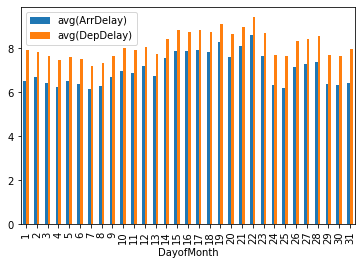

In [18]:
question_2 = all_tables.groupBy(col('DayofMonth')).mean('ArrDelay', 'DepDelay').sort('DayofMonth')
question_2.show()
question_2.toPandas().plot(x='DayofMonth', y=['avg(ArrDelay)', 'avg(DepDelay)'], kind='bar')

When is the best time of the month of the year to fly to avoid delays?


+-----+------------------+------------------+
|Month|     avg(ArrDelay)|     avg(DepDelay)|
+-----+------------------+------------------+
|    1| 8.429739020654077|  9.28327635481392|
|    2| 7.890012028806683| 8.828780243757839|
|    3|  7.24424920498482| 8.536374327029595|
|    4| 5.253459694828195| 6.683271286973579|
|    5| 5.453798149002377|6.6572778811246005|
|    6|  9.47868141412949| 9.894755345882906|
|    7|  8.77275818853854|  9.58783224706365|
|    8| 7.812242905430606| 8.638854672852112|
|    9|3.5725391250161653|  5.25088034747227|
|   10| 4.996409383049272| 6.172380485803541|
|   11| 5.463129580068729| 6.934113853822614|
|   12| 10.12150371158294|10.991860348622419|
+-----+------------------+------------------+



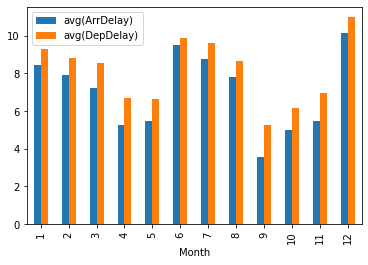

In [19]:
question_3 = all_tables.groupBy(col('Month')).mean('ArrDelay', 'DepDelay').sort('Month')
question_3.show()
question_3.toPandas().plot(x='Month', y=['avg(ArrDelay)', 'avg(DepDelay)'], kind='bar')

What is the best/worst carrier to avoid delay?


In [ ]:
question_4_best = all_tables.groupBy(col('Description')).mean('ArrDelay').sort(col('avg(ArrDelay)').asc()).take(1)
question_4_worst = all_tables.groupBy(col('Description')).mean('ArrDelay').sort(col('avg(ArrDelay)').desc()).take(1)
print('-- Best carrier --')
print('Name: ' + question_4_best[0]['Description'])
print('Average delay time ' + str("{:.2f}".format(question_4_best[0]['avg(ArrDelay)'])) + ' mins')

print('\n-- Worst carrier --')
print('Name: ' + question_4_worst[0]['Description'])
print('Average delay time ' + str("{:.2f}".format(question_4_worst[0]['avg(ArrDelay)'])) + ' mins')

-- Best carrier --
Name: Hawaiian Airlines Inc.
Average deplay time -1.35 mins

-- Worst carrier --
Name: Mesa Airlines Inc.
Average deplay time 11.53 mins


How does the number of flight in BOS airport change over time?



+----+------+
|Year| count|
+----+------+
|1987| 25250|
|1988| 99921|
|1989| 91600|
|1990| 94092|
|1991| 91360|
|1992| 93521|
|1993| 95331|
|1994|100365|
|1995| 92852|
|1996| 93213|
|1997| 98268|
|1998| 98415|
|1999|107790|
|2000|113056|
|2001|133013|
|2002|109820|
|2003|115460|
|2004|132339|
|2005|128006|
|2006|131050|
+----+------+
only showing top 20 rows



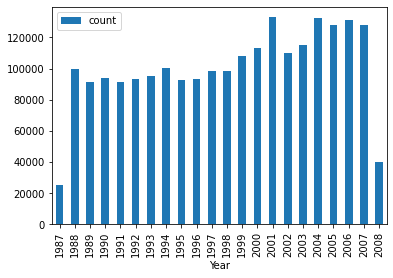

In [ ]:
question_5 = all_tables.filter(all_tables.Origin == 'BOS').groupBy(col('Year')).count().sort('Year')
question_5.show()
question_5.toPandas().plot(x="Year", y="count", kind="bar")


# **Results**
+ Question 1: When is the best time of day of the week to fly to avoid delay?
    According to data, Friday and Thursday are most likely to have delays. Surprisingly, Saturday is the best day of the week to avoid delay.  I thought Saturday is the day most people go places because it's the weekend and not a lot of people work on Saturday.
+ Question 2: When is the best time of day of the month to fly to avoid delays?
    There is not much fluctuation in days of the month. That makes sense because people are more likely to travel on Friday and Thursday; Over many years, all days of the week will be evenly distributed to all days of the month. For example, over many years, the amount of Mondays that fall into the 1st of the month is quite close to any other day of the week.

+ Question 3: When is the best time of the month of the year to fly to avoid delays?
    According to data, the average delay time for September is the lowest while December is the highest. That is reasonable because Christmas Eve and New Year are in December. Therefore, there are a lot of people traveling.

- Question 4: What is the best/worst carrier to avoid delay?
    Mesa Airlines Inc. is most likely to have delays with an average delay time of 11 mins while Hawaiian Airlines Inc. with an average delay time of -1 minute

+ Question 5: How does the number of flights in BOS airport change over time?
    The number of flights had been increasing steadily every year until 2005. It kind of flattened out after 2005. I did some googling on why there are more flights in 2001 than in other years. But there is no result talking about it on google.




# **Conclusion**
- It was interesting to use Spark to find some meaningful information about the data and see how much nicer is Spark compared to Hadoop. However, all of my computation is very slow since there are 16GB of data. It would be cool if I can run code on a real distributed system and see how fast it runs instead of running a simulated environment. If I had more time, I would pick another set of data and come up with some questions that use a lot of iterative tasks. That way I can see how fast it runs.


